# 신용카드 서비스 이탈 여부 예측하기


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

- 원본 데이터셋의 마지막 두 열에는 데이터셋 업로더가 만든 Naive Bayes 알고리즘의 예측값이 들어있기 때문에 분석을 위해서 이 컬럼들을 drop 해준다.

In [33]:
df = pd.read_csv('/content/drive/MyDrive/EURON/BankChurners.csv')
df = df[df.columns[:-2]]
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1              44  ...                       1                      2   
2              36  ...                       1                      0   
3              34  ...                       4                      1   
4              21  ...                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000  

[5 rows x 21 columns]

## 데이터셋 특성 살펴보기

In [34]:
print('### 학습 데이터 정보 ###  \n')
df.info()

### 학습 데이터 정보 ###  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null

- plotly를 사용하여 고객 연령 분포 살펴보기

In [35]:
#고객 연령 분포
fig = make_subplots(rows=2, cols=1)
tr1 = go.Box(x=df['Customer_Age'], name='Age Box Plot', boxmean='sd')
tr2 = go.Histogram(x=df['Customer_Age'], name='Age Histogram')
fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=2, col=1)
fig.update_layout(height=500, width=600, title_text="Distribution of Customer Ages")
fig.show()

In [36]:
#소득과 교육 수준 분포
education = pd.DataFrame(df['Education_Level'].value_counts())
labelsedu = df['Education_Level'].unique()
income = pd.DataFrame(df['Income_Category'].value_counts())
labelincome = df['Income_Category'].unique()
#explore education level and income level
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
tr3 = go.Pie(labels=labelsedu, values=education.iloc[:,0], name='proportion of Education Level')
tr4 = go.Pie(labels=labelincome, values=income.iloc[:,0], name='Proportion Of Different Income Levels')
fig.add_trace(tr3, row=1, col=1)
fig.add_trace(tr4, row=1, col=2)
fig.update_layout(height=500, width=600, title_text="Distribution of Income and Education level")
fig.show()

## PCA 수행
- 기존 고객을 1, 이탈 고객을 0으로 예측한다
- 주요 주성분 2개만 사용하고 그 다음에 3개 및 4개의 주요 주성분을 탐색한다.

In [37]:
x = df.iloc[:,9:21] #assign column 9 to 21 as x variable - the features
x = StandardScaler().fit_transform(x) #standarize the variables
df['Attrition_Flag'].replace('Existing Customer','1',inplace=True)
df['Attrition_Flag'].replace('Attrited Customer','0',inplace=True)
y = df['Attrition_Flag'] #assign y variable - the target

In [38]:
pca = PCA(n_components=2) #2개의 주요 주성분만 사용
PC = pca.fit_transform(x)
principalDF = pd.DataFrame(data=PC,columns=['pc1', 'pc2'])
finalDf = pd.concat([principalDF, df[['Attrition_Flag']]], axis = 1)
finalDf.head()

pc1       pc2 Attrition_Flag
0  0.276048 -0.617639              1
1 -0.612402  1.430502              1
2 -0.613733  1.098632              1
3 -2.499317  1.781346              1
4 -0.560120  0.924119              1

- 나중의 예측에서 각 특성이 얼마나 중요한지 평가하기 위해 'Loadings table'을 구성할 수 있다.
- Loadings는 각각의 원래 특성이 "새로운 특성"인 주성분에 얼마나 기여했는지 보여준다.

In [39]:
PCloadings = pca.components_.T * np.sqrt(pca.explained_variance_)
components = df.columns.tolist()
components = components[9:21]
loadingdf = pd.DataFrame(PCloadings, columns=('PC1', 'PC2'))
loadingdf["variable"] = components
loadingdf

PC1       PC2                  variable
0  -0.012248 -0.084536            Months_on_book
1  -0.276207 -0.384630  Total_Relationship_Count
2  -0.030992 -0.105797    Months_Inactive_12_mon
3  -0.017396 -0.314187     Contacts_Count_12_mon
4   0.867614 -0.180299              Credit_Limit
5  -0.261374  0.402668       Total_Revolving_Bal
6   0.890865 -0.216361           Avg_Open_To_Buy
7  -0.012135  0.181603      Total_Amt_Chng_Q4_Q1
8   0.467479  0.763757           Total_Trans_Amt
9   0.359458  0.788716            Total_Trans_Ct
10 -0.012862  0.309368       Total_Ct_Chng_Q4_Q1
11 -0.718652  0.411826     Avg_Utilization_Ratio

In [40]:
# plot으로 나타내서 살펴보기
fig = ex.scatter(x=loadingdf['PC1'], y=loadingdf['PC2'], text=loadingdf['variable'])
fig.update_layout(
    height=600,
    width=500,
    title_text='loadings plot'
)
fig.update_traces(textposition='bottom center')
fig.add_shape(type="line", x0=-0, y0=-0.5, x1=-0, y1=2.5, line=dict(color="RoyalBlue", width=3))
fig.add_shape(type="line", x0=-1, y0=0, x1=1, y1=0, line=dict(color="RoyalBlue", width=3))
fig.show()

-  총 거래 횟수, 총 거래 금액(total transaction count, total transaction amount)

    : 두 가지 특성이 매우 큰 가중치를 갖고 있음.
- 예측이 상당히 높은 정확도를 가진다면, 이 두 가지 특성이 실제로 고객 이탈을 결정하는 데 중요한 요소임을 추론할 수 있다.

### 산점도로 주성분에 따른 데이터 분포 확인

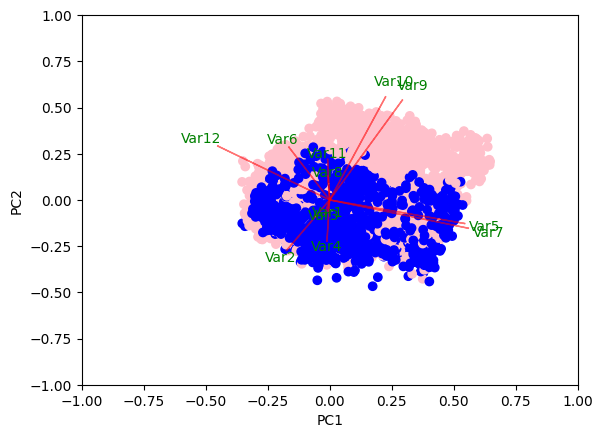

In [41]:
# 산점도로 주성분에 따른 데이터 분포 확인
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    colors = {'1':'pink', '0':'blue'}
    plt.scatter(xs * scalex,ys * scaley, c= y.apply(lambda x: colors[x]))
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))

myplot(PC[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

## 로지스틱 회귀모델을 이용한 예측 수행

1. 데이터셋을 훈련 세트와 테스트 세트로 분할합니다.
2. 훈련 세트에 로지스틱 회귀를 적용합니다.
3. 테스트 세트에 대한 예측을 수행합니다.
4. 테스트 세트에서 예측 점수를 출력합니다.

In [42]:
# 로지스틱 회귀 적용
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
Xfinal = finalDf[['pc1','pc2']]
yfinal = finalDf['Attrition_Flag']
X_train, X_test, y_train, y_test = train_test_split(Xfinal,yfinal,test_size=0.3)
logistic = LogisticRegression()
logistic.fit(X=X_train,y=y_train)
logistic.predict(X_test)
score_2 = logistic.score(X_test,y_test)

### 3, 4개 주성분으로 PCA 수행

In [43]:
# n_components = 3
pca = PCA(n_components=3)
PC = pca.fit_transform(x)
principalDF = pd.DataFrame(data=PC, columns=['pc1', 'pc2', 'pc3'])
finalDF = pd.concat([principalDF, df[['Attrition_Flag']]], axis=1)
Xfinal = finalDF[['pc1', 'pc2', 'pc3']]
yfinal = finalDF['Attrition_Flag']
X_train, X_test, y_train, y_test = train_test_split(Xfinal, yfinal, test_size=0.3)
#로지스틱 회귀 적용
logistic = LogisticRegression()
logistic.fit(X=X_train, y=y_train)
logistic.predict(X_test)
score_3 = logistic.score(X_test, y_test)

In [44]:
# n_components = 4
pca = PCA(n_components=4)
PC = pca.fit_transform(x)
principalDF = pd.DataFrame(data=PC, columns=['pc1', 'pc2', 'pc3', 'pc4'])
finalDF = pd.concat([principalDF, df[['Attrition_Flag']]], axis=1)
Xfinal = finalDF[['pc1', 'pc2', 'pc3', 'pc4']]
yfinal = finalDF['Attrition_Flag']
X_train, X_test, y_train, y_test = train_test_split(Xfinal, yfinal, test_size=0.3)
#로지스틱 회귀 적용
logistic = LogisticRegression()
logistic.fit(X=X_train, y=y_train)
logistic.predict(X_test)
score_4 = logistic.score(X_test, y_test)

In [45]:
scores = [score_2, score_3, score_4]
scores

[0.8519249753208292, 0.8762750904902928, 0.876604146100691]

In [46]:
ex.bar(y=scores,x=('pc2','pc3','pc4'),range_y=(0.7,0.9),title='PC prediction accuracy')

**※ 중간에 코드에 오류가 있었는지 예측 결과가 다르게 출력되었습니다.**

결과적으로 원본 노트북에서는 3개의 주요 주성분이 가장 높은 점수를 얻었지만, 이미 2개의 주요 주성분으로 84%의 비교적 훌륭한 정확도를 달성했다.

따라서 **총 거래 횟수와 총 거래 금액**이 고객 이탈을 예측하는 데 좋은 예측 변수임을 추론할 수 있다.

## 도전과제
- leading principal components를 1부터 10까지 1씩 증가시키면서 PCA를 적용해 보세요.
 - leading principal components가 어떤 값일 때 가장 성능이 좋나요?
- 위의 결과를 이용하여 그래프로 시각화를 해보세요. 그래프의 종류는 무엇이든 괜찮습니다.
Hint: Scree Plot

### 주성분의 개수를 1부터 10까지 변화시키면서 PCA 적용

In [47]:
x = df.iloc[:,9:21] #assign column 9 to 21 as x variable - the features
x = StandardScaler().fit_transform(x) #standarize the variables
df['Attrition_Flag'].replace('Existing Customer','1',inplace=True)
df['Attrition_Flag'].replace('Attrited Customer','0',inplace=True)
y = df['Attrition_Flag'] #assign y variable - the target

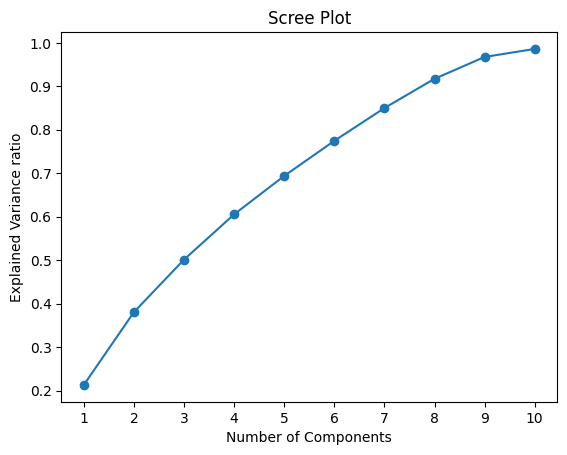

In [51]:
res_list = []

for n_components in range(1, 11):
    # PCA 모델 생성 및 학습
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(x)

    # 전체 변동성에서 개별 PCA 컴포넌트별로 차지하는 변동성 비율 저장
    res_list.append(np.sum(pca.explained_variance_ratio_))

# Scree plot 그리기
plt.plot(range(1,11), res_list, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance ratio')
plt.title('Scree Plot')
plt.xticks(np.arange(1, 11, 1))
plt.show()

### 결과
- leading principal components가 10일 때 가장 성능이 좋다.